In [43]:
# importing all necessary libraries
import tensorflow
import matplotlib
import keras
import numpy
import sklearn

import pydot


import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as kb

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from sklearn.metrics import roc_curve,RocCurveDisplay,auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(tf.__version__)

2.7.0


In [13]:
if (len(tf.config.experimental.list_physical_devices('GPU')) == 1):
    print("GPU is detected")

In [14]:
BATCH_SIZE = 16
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
VALIDATION_SPLIT = 0.2
EPOCHS = 50
STEPS_PER_EPOCH = 1000

In [48]:
PATH_DATASET = os.path.join('./Dataset')
PATH_DATASET_TEST = os.path.join('./datasets_test')
PATH_SAVE_MODEL = os.path.join('./model/CNNN.h5')

In [16]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'training',
)

dataset_test = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'validation',
)

CLASSES = dataset_train.class_names
NB_CLASSES = len(dataset_train.class_names)
print(f'Le dataset comporte {NB_CLASSES} classes : {CLASSES}')

Found 20071 files belonging to 2 classes.
Using 16057 files for training.
Found 20071 files belonging to 2 classes.
Using 4014 files for validation.
Le dataset comporte 2 classes : ['Other', 'Photo']


In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset_train = dataset_train.cache().prefetch(buffer_size=AUTOTUNE)
dataset_test = dataset_test.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
data_augmentation = keras.Sequential([
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(0.2, fill_mode='reflect',
                          interpolation='bilinear', fill_value=0.0),
    layers.RandomZoom(0.2),
])

In [19]:
model = tf.keras.Sequential([
    data_augmentation,

    layers.Rescaling(
        1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
        
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling2D(),
    # layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


In [20]:
# precision =  true positives / (true positives + false positives)
def precision(y_true, y_pred):
    true_positives = kb.sum(kb.round(kb.clip(y_true * y_pred, 0, 1)))
    predicted_positives = kb.sum(kb.round(kb.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + kb.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = kb.sum(kb.round(kb.clip(y_true * y_pred, 0, 1)))
    possible_positives = kb.sum(kb.round(kb.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + kb.epsilon())
    return recall

# f1 score
def f1_score(y_true, y_pred):
    true_positives = kb.sum(kb.round(kb.clip(y_true * y_pred, 0, 1)))
    predicted_positives = kb.sum(kb.round(kb.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + kb.epsilon())
    possible_positives = kb.sum(kb.round(kb.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + kb.epsilon())
    f1_score = 2*(precision*recall)/(precision+recall+kb.epsilon())
    return f1_score


model.compile(
    optimizer = 'adam',
    loss = tf.losses.BinaryCrossentropy(),
    metrics = ['accuracy', f1_score, precision, recall])

In [21]:
def statistics(model_save) :
    acc = model_save.history['accuracy']
    val_acc = model_save.history['val_accuracy']

    loss = model_save.history['loss']
    val_loss = model_save.history['val_loss']

    plt.figure(figsize=(12, 5))
    plt.ylim([0, 1])
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.ylim([0, 1])
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [51]:
def get_model(newModel=True):
    if newModel == True:
        with tf.device('/device:GPU:0'):
            model_history = model.fit(dataset_train.repeat(), validation_data = dataset_test, epochs = EPOCHS, steps_per_epoch = STEPS_PER_EPOCH)
        statistics(model_history)
        keras.models.save_model(model, PATH_SAVE_MODEL)
        return model
    else :
        return keras.models.load_model(PATH_SAVE_MODEL, custom_objects={'f1_score':f1_score, 'precision':precision, 'recall':recall})   

model = get_model(newModel=False)


![Statistiques de l'entraînement](./img/model_statistics.png "Statistiques de l'entraînement")

251/251 [==============================] - 41s 162ms/step - loss: 0.2453 - accuracy: 0.9175 - f1_score: 0.9114 - precision: 0.9379 - recall: 0.8975
Test loss: 0.2452578991651535
Test accuracy: 0.9175386428833008
Test F1 Score : 0.9114054441452026
Test Precision : 0.9378625750541687
Test Recall : 0.897480845451355


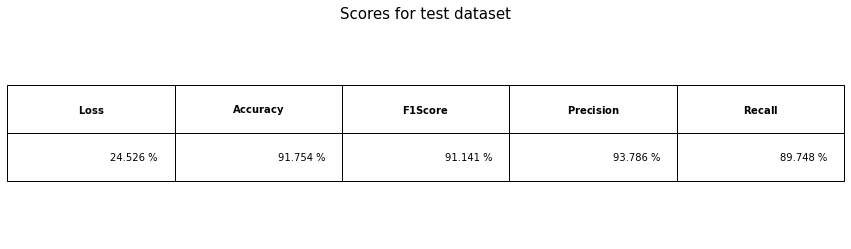

In [40]:
model_evaluation = model.evaluate(dataset_test)


print('Test loss:', model_evaluation[0])
print('Test accuracy:', model_evaluation[1])
print('Test F1 Score :', model_evaluation[2])
print('Test Precision :', model_evaluation[3])
print('Test Recall :', model_evaluation[4])

fig, ax = plt.subplots(1, 1)
column_labels = ["$\\bf{Loss}$",
                 "$\\bf{Accuracy}$",
                 "$\\bf{F1Score}$",
                 "$\\bf{Precision}$",
                 "$\\bf{Recall}$"]
ax.axis('tight')
ax.axis('off')
plt.title('Scores for test dataset', fontsize=15)
table = ax.table(cellText=[['%.3f %%' % (
    i*100) for i in model_evaluation]], colLabels=column_labels, loc="center")
table.scale(2.5, 4)
plt.show()


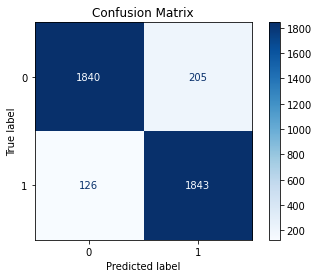

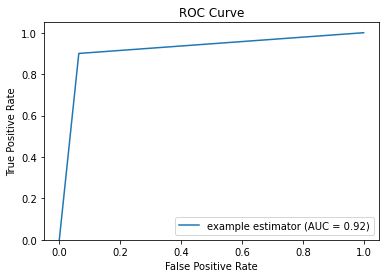

In [41]:
def transformPrediction(n):
    return 0 if n < 0.5 else 1

# Partie de génération de matrice de confusion
preds = model.predict(dataset_test)
predicted_categories = list(map(transformPrediction, preds))
true_categories = tf.concat([y for x, y in dataset_test], axis=0)
con_mat = confusion_matrix(predicted_categories, true_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

# Partie de génération de courbe ROC
fpr, tpr, _ = roc_curve(true_categories, predicted_categories)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.title('ROC Curve')
plt.ylim(0,)
plt.show()

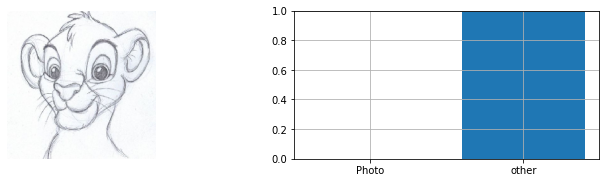

This image is 0.00 % a photo and 100.00 % other.


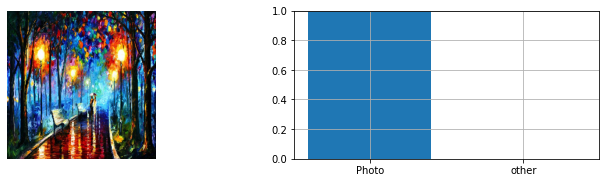

This image is 99.97 % a photo and 0.03 % other.


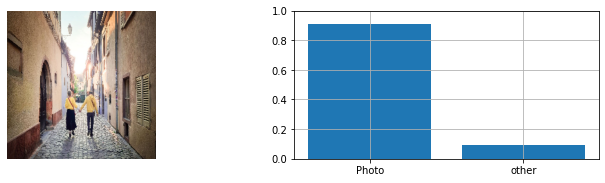

This image is 90.96 % a photo and 9.04 % other.


In [49]:
for pictures in os.listdir(PATH_DATASET_TEST):
    img = image.load_img((PATH_DATASET_TEST + "/" + pictures), target_size = (IMAGE_HEIGHT, IMAGE_WIDTH))
    
    plt.figure(figsize=(12,6))
    plt.subplot(2,2,1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.binary)
    
    img  = image.img_to_array(img)
    img  = img.reshape((1,) + img.shape)
    
    prediction = model.predict(img)

    score = prediction[0][0]
    other_score = (1 - score)

    formatted_photo_score = 100 * score
    formatted_other_score = 100 * other_score

    score_array = [score,other_score]

    plt.subplot(2,2,2)
    plt.grid(True)
    plt.bar(["Photo","other"], score_array)
    #plt.xticks(range(NB_CLASSES), ["Photo","other"], rotation = 45)
    plt.ylim([0, 1])
    plt.show()
    
    print("This image is %.2f %% a photo and %.2f %% other." % (score*100, other_score*100))
    

In [44]:
keras.utils.plot_model(model, show_shapes=True, dpi=64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
